In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# Adding path to module
sys.path.append("../")

# picture path
PICS = '../pics/'

# Module imports
from fourth_day import Fourth_Day, config

# Some example settings
# Scenario
config['scenario']['population size'] = 1000
config['scenario']['encounters'] = True
config['scenario']['exclusion'] = False
config['scenario']['injection']['rate'] = 0
config['scenario']['duration'] = 200
config['organisms']['emission fraction'] = 0.5
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 0.1,
    'y_length': 0.1,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 0.1,
    'y_length': 0.1,
    'offset': None,
}
# Water
config['water']['model']['name'] = 'none'
config['water']['model']['time step'] = 1

# Plotting standards
std_size = 10.
fontsize = 20.
lw=3.
h_length=1.5

In [2]:
# Creating a fourth_day object
fd = Fourth_Day()
# Launching solver
fd.sim()

In [3]:
'''
this wavelength_attentuation function is extract from 
https://pdfs.semanticscholar.org/1e88/9ce6ebf1ec84ab1e3f934377c89c0257080c.pdf
by https://apps.automeris.io/wpd/ Plot digitizer read points
'''
wavelength_data = [399.44415494181,412.07970421102266,425.75250006203635,442.53703565845314,
                   457.1974490682151,471.8380108687561,484.3544504826423,495.7939402962853,509.29799746891985,
                  519.6903148961513,530.0627807141617,541.5022705278046,553.9690811186382,567.4929899004939,
                  580.9771954639073,587.1609717362714,593.3348222040249,599.4391920395047,602.4715253480235]
attenuation_data = [0.026410321551339357,0.023168667048510762,0.020703255370450736,0.019552708373076478,
                    0.019526153330089138,0.020236306473695613,0.02217620815962483,0.025694647290888873,
                    0.031468126242251794,0.03646434475343956,0.04385011375530569,0.05080729755501162,
                    0.061086337538657706,0.07208875589035815,0.09162216168767365,0.11022281058708046,
                   0.1350811713674855,0.18848851206491904,0.23106528395398912]

#interplote from 400nm to 600nm
from scipy import interpolate
attenuation_wavelength_function = interpolate.interp1d(wavelength_data, attenuation_data, kind='quadratic')

#default detector position
detector_pos =[5.,10.]

'''
this function calculate light intensity after propagation in seawater
using formula I=I_0*(1/R^2) * exp(k*R), where R is light path length, k = attenuation + scattering coefficient
'''
def propagation(photon_number, pos_x, pos_y, wavelength):
    
    path = np.sqrt( (pos_x-detector_pos[0])**2+(pos_y-detector_pos[1])**2) # in m
    attenuation_factor = attenuation_wavelength_function(wavelength) # [m^-1]
    intensity = photon_number*np.exp(path*attenuation_factor)/(path)**2
    
    return intensity

In [4]:
sum_intensity_list = []
#for every time interval, when light was emitted, then save position and encounter photon for this species
for i in range(len(fd.t)):
    masked_encounter_photons = np.ma.masked_where(fd.statistics[i].loc[:, 'is_emitting'].values == False, fd.statistics[0].loc[:, 'encounter photons'].values)
    masked_pos_x = np.ma.masked_where(fd.statistics[i].loc[:, 'is_emitting'].values == False, fd.statistics[0].loc[:, 'pos_x'].values)
    masked_pos_y = np.ma.masked_where(fd.statistics[i].loc[:, 'is_emitting'].values == False, fd.statistics[0].loc[:, 'pos_y'].values)
    masked_species = np.ma.masked_where(fd.statistics[i].loc[:, 'is_emitting'].values == False, fd.statistics[0].loc[:, 'species'].values)

    encounter_photons = masked_encounter_photons.compressed()
    pos_x = masked_pos_x.compressed()
    pos_y = masked_pos_y.compressed()
    species = masked_species.compressed()

    #wavelength info for this emittion is extracted from its pdf mean value
    emit_wavelength = []
    for species_key in species:
        wavelength_mean = fd._life.Light_pdfs[species_key]._mean
        emit_wavelength.append(wavelength_mean)
        
    #calculate new intensity after propagation    
    intensity_list =[]
    for i in range(len(species)):
        new_intensity = propagation(encounter_photons[i], pos_x[i], pos_y[i], emit_wavelength[i])
        intensity_list.append(new_intensity)
    sum_intensity_list.append(np.sum(intensity_list))

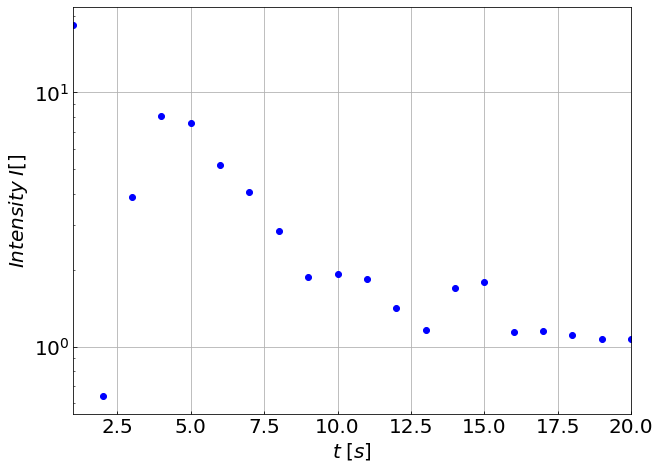

In [6]:
#plot
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.plot(fd.t,sum_intensity_list,'bo')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(1e0, 2e1)# max(fd.t))
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Intensity\;I[]$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
plt.show()